In [2]:
from google.colab import files
import zipfile
import os

# Upload the dataset zip file
uploaded = files.upload()

# Extract the zip file
zip_file_path = list(uploaded.keys())[0]  # Get the name of the uploaded file
extraction_path = '/content/animal_classification'  # Path where files will be extracted

# Extract the contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Verify the structure of the extracted data
extracted_files = os.listdir(extraction_path)
extracted_files

Saving dataset.zip to dataset (1).zip


['dataset']

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the extracted dataset
train_dir = '/content/animal_classification/dataset'

# Set up ImageDataGenerator with data normalization and validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalizing pixel values to [0, 1]

# Create data generators for training and validation sets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Use 80% of the data for training
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use 20% of the data for validation
)

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load VGG16 model without the top (fully connected) layers, using ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to retain pre-trained features
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for classification
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
output = Dense(15, activation='softmax')(x)  # 15 classes for 15 animal types

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Train the model for 20 epochs
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 1070s 22s/step - accuracy: 0.1715 - loss: 4.3391 - val_accuracy: 0.5085 - val_loss: 1.7202
Epoch 2/20
 1/48 ━━━━━━━━━━━━━━━━━━━━ 14:51 19s/step - accuracy: 0.5000 - loss: 1.6531

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 365ms/step - accuracy: 0.5000 - loss: 1.6531 - val_accuracy: 0.4839 - val_loss: 1.8154
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1062s 22s/step - accuracy: 0.4686 - loss: 1.6447 - val_accuracy: 0.5028 - val_loss: 1.5124
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 351ms/step - accuracy: 0.4062 - loss: 1.9916 - val_accuracy: 0.5806 - val_loss: 1.4381
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1057s 22s/step - accuracy: 0.6279 - loss: 1.2078 - val_accuracy: 0.5852 - val_loss: 1.3541
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.8000 - loss: 0.6422 - val_accuracy: 0.6452 - val_loss: 1.2481
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1082s 22s/step - accuracy: 0.6791 - loss: 0.9971 - val_accuracy: 0.5938 - val_loss: 1.2499
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 356ms/step - accuracy: 0.8438 - loss: 0.5677 - val_accuracy: 0.5484 - val_loss: 1.4888
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1067s 22s/step - accuracy: 0.7181 - loss: 0.8970 - val_accuracy: 0.571

12/12 ━━━━━━━━━━━━━━━━━━━━ 215s 18s/step - accuracy: 0.6478 - loss: 1.1510
Validation Accuracy: 58.75%
12/12 ━━━━━━━━━━━━━━━━━━━━ 220s 18s/step


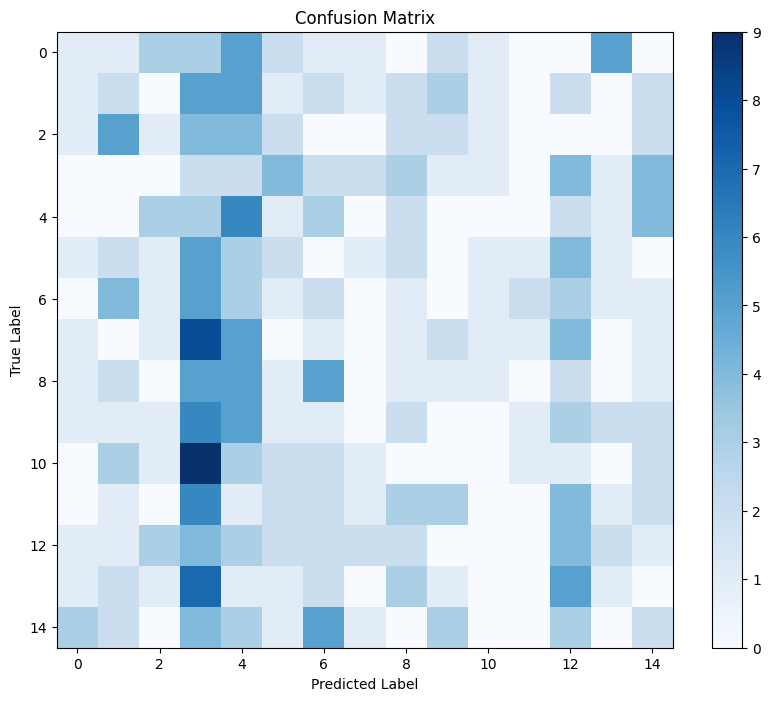

In [7]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Generate a confusion matrix for further analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=-1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [8]:
from google.colab import files
uploaded = files.upload()

# After upload, get the filename
img_path = list(uploaded.keys())[0]
print(f"Uploaded file path: {img_path}")



Saving Bird_4_1.jpg to Bird_4_1.jpg
Uploaded file path: Bird_4_1.jpg


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
class_labels = list(train_generator.class_indices.keys())  # Retrieve class labels
print(f"The model predicts: {class_labels[predicted_class]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
The model predicts: Bird
